# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [2]:
df = pd.read_csv('C:/Users/Iweimer/Desktop/BB_Git/1083-albumin-data-exploration/ML/K70_Cohort/K70_matched.csv')

In [4]:
df.LOS_days.describe()

count    13288.000000
mean         7.564139
std          7.645436
min          0.000000
25%          2.639583
50%          5.147917
75%          9.934375
max         54.840972
Name: LOS_days, dtype: float64

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [6]:
df[df['albumin_24hrs'] == 1].LOS_days.describe()

count    6644.000000
mean        8.346971
std         8.023175
min         0.080556
25%         2.964583
50%         5.893750
75%        11.168006
max        54.840972
Name: LOS_days, dtype: float64

In [7]:
df[df['albumin_24hrs'] == 0].LOS_days.describe()

count    6644.000000
mean        6.781306
std         7.163589
min         0.000000
25%         2.191319
50%         4.726273
75%         8.754861
max        54.496528
Name: LOS_days, dtype: float64

## Convert LOS_days to Categorical

In [8]:
# Calculate Tertiles

q1 = df['LOS_days'].quantile(q=(1/3))
q2 = df['LOS_days'].quantile(q=(2/3))
print(q1)
print(q2)

3.3104166666666655
7.877083333333324


In [9]:
# bin the LOS_days var

LOS = df['LOS_days']
m = max(LOS)

bins = [0, 3.31, 7.88, m]
labels=[0, 1, 2]

# 0 - Low/Short Length of Stay
# 1 - Medium Length of Stay
# 2 - High/Long Length of Stay

df['LOS_days'] = pd.cut(LOS, bins=bins, labels=labels, include_lowest=True)

In [10]:
df['LOS_days'].value_counts()

1    4434
0    4429
2    4425
Name: LOS_days, dtype: int64

In [11]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA    MELD  \
0  07ea020e-dbef-418c-b4b2-be3d104ba6be    0          1    2      1  22.000   
1  03255b92-d10f-41fd-8387-9e223f9be912    0          1    3      0  16.574   
2  1dc64909-cbe3-46e2-94ae-7c6de6a38364    0          1   10      0  18.000   
3  47905ac2-9758-4da5-adc5-1349c4c232a9    0          1    2      0  18.000   
4  f0f847d0-a8c0-4d11-b500-110f6f495f1b    0          1    6      0   8.000   

   SEWS  propensity_score  propensity_logit  albumin_24hrs  \
0     2          0.635804          0.557197              1   
1     0          0.390010         -0.447270              1   
2     0          0.591606          0.370610              1   
3     0          0.401814         -0.397912              1   
4     0          0.262973         -1.030574              1   

                               personid LOS_days  90_day_mortality  \
0  0b195e78-8b4c-4885-a6f1-162738405bf4        2                 0   
1  0c08fc94-32eb-4e48-bd22-f075f911f7cb        1                 0   
2  0d35b91a-883d-43cb-ad15-31123a3008c8        2                 0   
3  14a7cf74-4469-4102-aac3-cdf906baa891        0                 0   
4  16e21cc6-4d8c-44b1-b5e6-206c5f466893        0                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 0.0                  77             2.0        1  
1                 0.0                  27             1.0        1  
2                 0.0                  78             1.0        1  
3                 0.0                  89             1.0        1  
4                 1.0                   1             1.0        1

In [12]:
df.shape

(13288, 17)

In [14]:
df.drop(columns=['encounterid', 'personid', 'propensity_score', 'propensity_logit', 'albumin', 'albumin_timing'], inplace=True)

In [15]:
df.drop(columns=['90_day_mortality', '90_day_readmission', 'hospital_free_days'], inplace=True)

In [16]:
df.head()

ICU  Cirrhosis  CCI  qSOFA    MELD  SEWS  albumin_24hrs LOS_days
0    0          1    2      1  22.000     2              1        2
1    0          1    3      0  16.574     0              1        1
2    0          1   10      0  18.000     0              1        2
3    0          1    2      0  18.000     0              1        0
4    0          1    6      0   8.000     0              1        0

In [68]:
# remove variables

# df.drop(columns=['anemia_status', 'SAPS', 'qSOFA', 'mass_transfusion'], inplace=True)

In [17]:
df.describe()

ICU     Cirrhosis           CCI         qSOFA          MELD  \
count  13288.000000  13288.000000  13288.000000  13288.000000  13288.000000   
mean       0.217113      0.891180      4.034317      0.698450     24.255708   
std        0.412296      0.311425      2.416956      0.772967      8.535608   
min        0.000000      0.000000      0.000000      0.000000      6.000000   
25%        0.000000      1.000000      3.000000      0.000000     18.376000   
50%        0.000000      1.000000      3.000000      1.000000     24.620000   
75%        0.000000      1.000000      5.000000      1.000000     30.330000   
max        1.000000      1.000000     17.000000      3.000000     40.000000   

               SEWS  albumin_24hrs  
count  13288.000000   13288.000000  
mean       1.379741       0.500000  
std        1.673190       0.500019  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        1.000000       0.500000  
75%        2.000000       1.000000  
max       12.000000       1.000000

In [18]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [19]:
# establish target feature, LOS_days, as y feature
y = df['LOS_days']
# drop target feature from features dataframe
X = df.drop(columns = ['LOS_days'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [20]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'MELD', 'SEWS', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [21]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [22]:
X.head()

ICU  Cirrhosis  CCI  qSOFA    MELD  SEWS  albumin_24hrs
0    0          1    2      1  22.000     2              1
1    0          1    3      0  16.574     0              1
2    0          1   10      0  18.000     0              1
3    0          1    2      0  18.000     0              1
4    0          1    6      0   8.000     0              1

## Train Test Split

In [23]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [24]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(multi_class='multinomial')

Feature: ICU Score: -0.39780
Feature: Cirrhosis Score: 0.09779
Feature: CCI Score: -0.09207
Feature: qSOFA Score: -0.10130
Feature: MELD Score: -0.01556
Feature: SEWS Score: -0.00518
Feature: albumin_24hrs Score: -0.25796


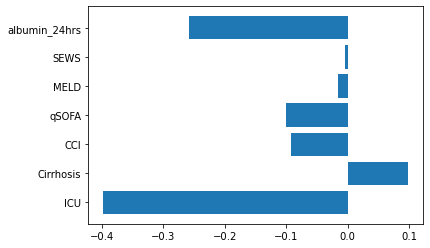

In [25]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
Cirrhosis        1.102734
SEWS             0.994838
MELD             0.984562
CCI              0.912042
qSOFA            0.903665
albumin_24hrs    0.772626
ICU              0.671799


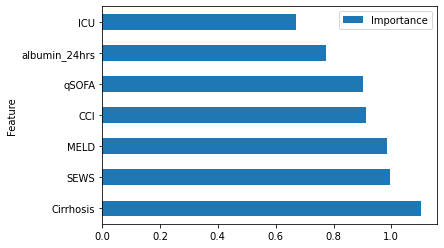

In [26]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [27]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [28]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2084  586  868]
 [1541  829 1202]
 [ 982  724 1814]]


In [29]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51      3538
           1       0.39      0.23      0.29      3572
           2       0.47      0.52      0.49      3520

    accuracy                           0.44     10630
   macro avg       0.44      0.45      0.43     10630
weighted avg       0.44      0.44      0.43     10630



In [30]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[506 151 234]
 [345 202 315]
 [244 191 470]]


In [31]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.46      0.57      0.51       891
           1       0.37      0.23      0.29       862
           2       0.46      0.52      0.49       905

    accuracy                           0.44      2658
   macro avg       0.43      0.44      0.43      2658
weighted avg       0.43      0.44      0.43      2658



## 1: Decision Tree (Max Depth=3)

In [76]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.11738
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.33177
Feature: CCI Score: 0.05050
Feature: bl_albumin_value Score: 0.00000
Feature: qSOFA Score: 0.08357
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.00000
Feature: SAPS Score: 0.19621
Feature: albumin_24hrs Score: 0.22057


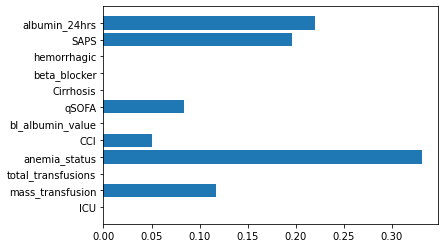

In [77]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [78]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [79]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1141  532 1079]
 [ 858  588 1350]
 [ 690  394 1678]]


In [80]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.42      0.41      0.42      2752
           1       0.39      0.21      0.27      2796
           2       0.41      0.61      0.49      2762

    accuracy                           0.41      8310
   macro avg       0.41      0.41      0.39      8310
weighted avg       0.41      0.41      0.39      8310



In [81]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[285 132 285]
 [218 143 326]
 [181  87 421]]


In [82]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.42      0.41      0.41       702
           1       0.40      0.21      0.27       687
           2       0.41      0.61      0.49       689

    accuracy                           0.41      2078
   macro avg       0.41      0.41      0.39      2078
weighted avg       0.41      0.41      0.39      2078



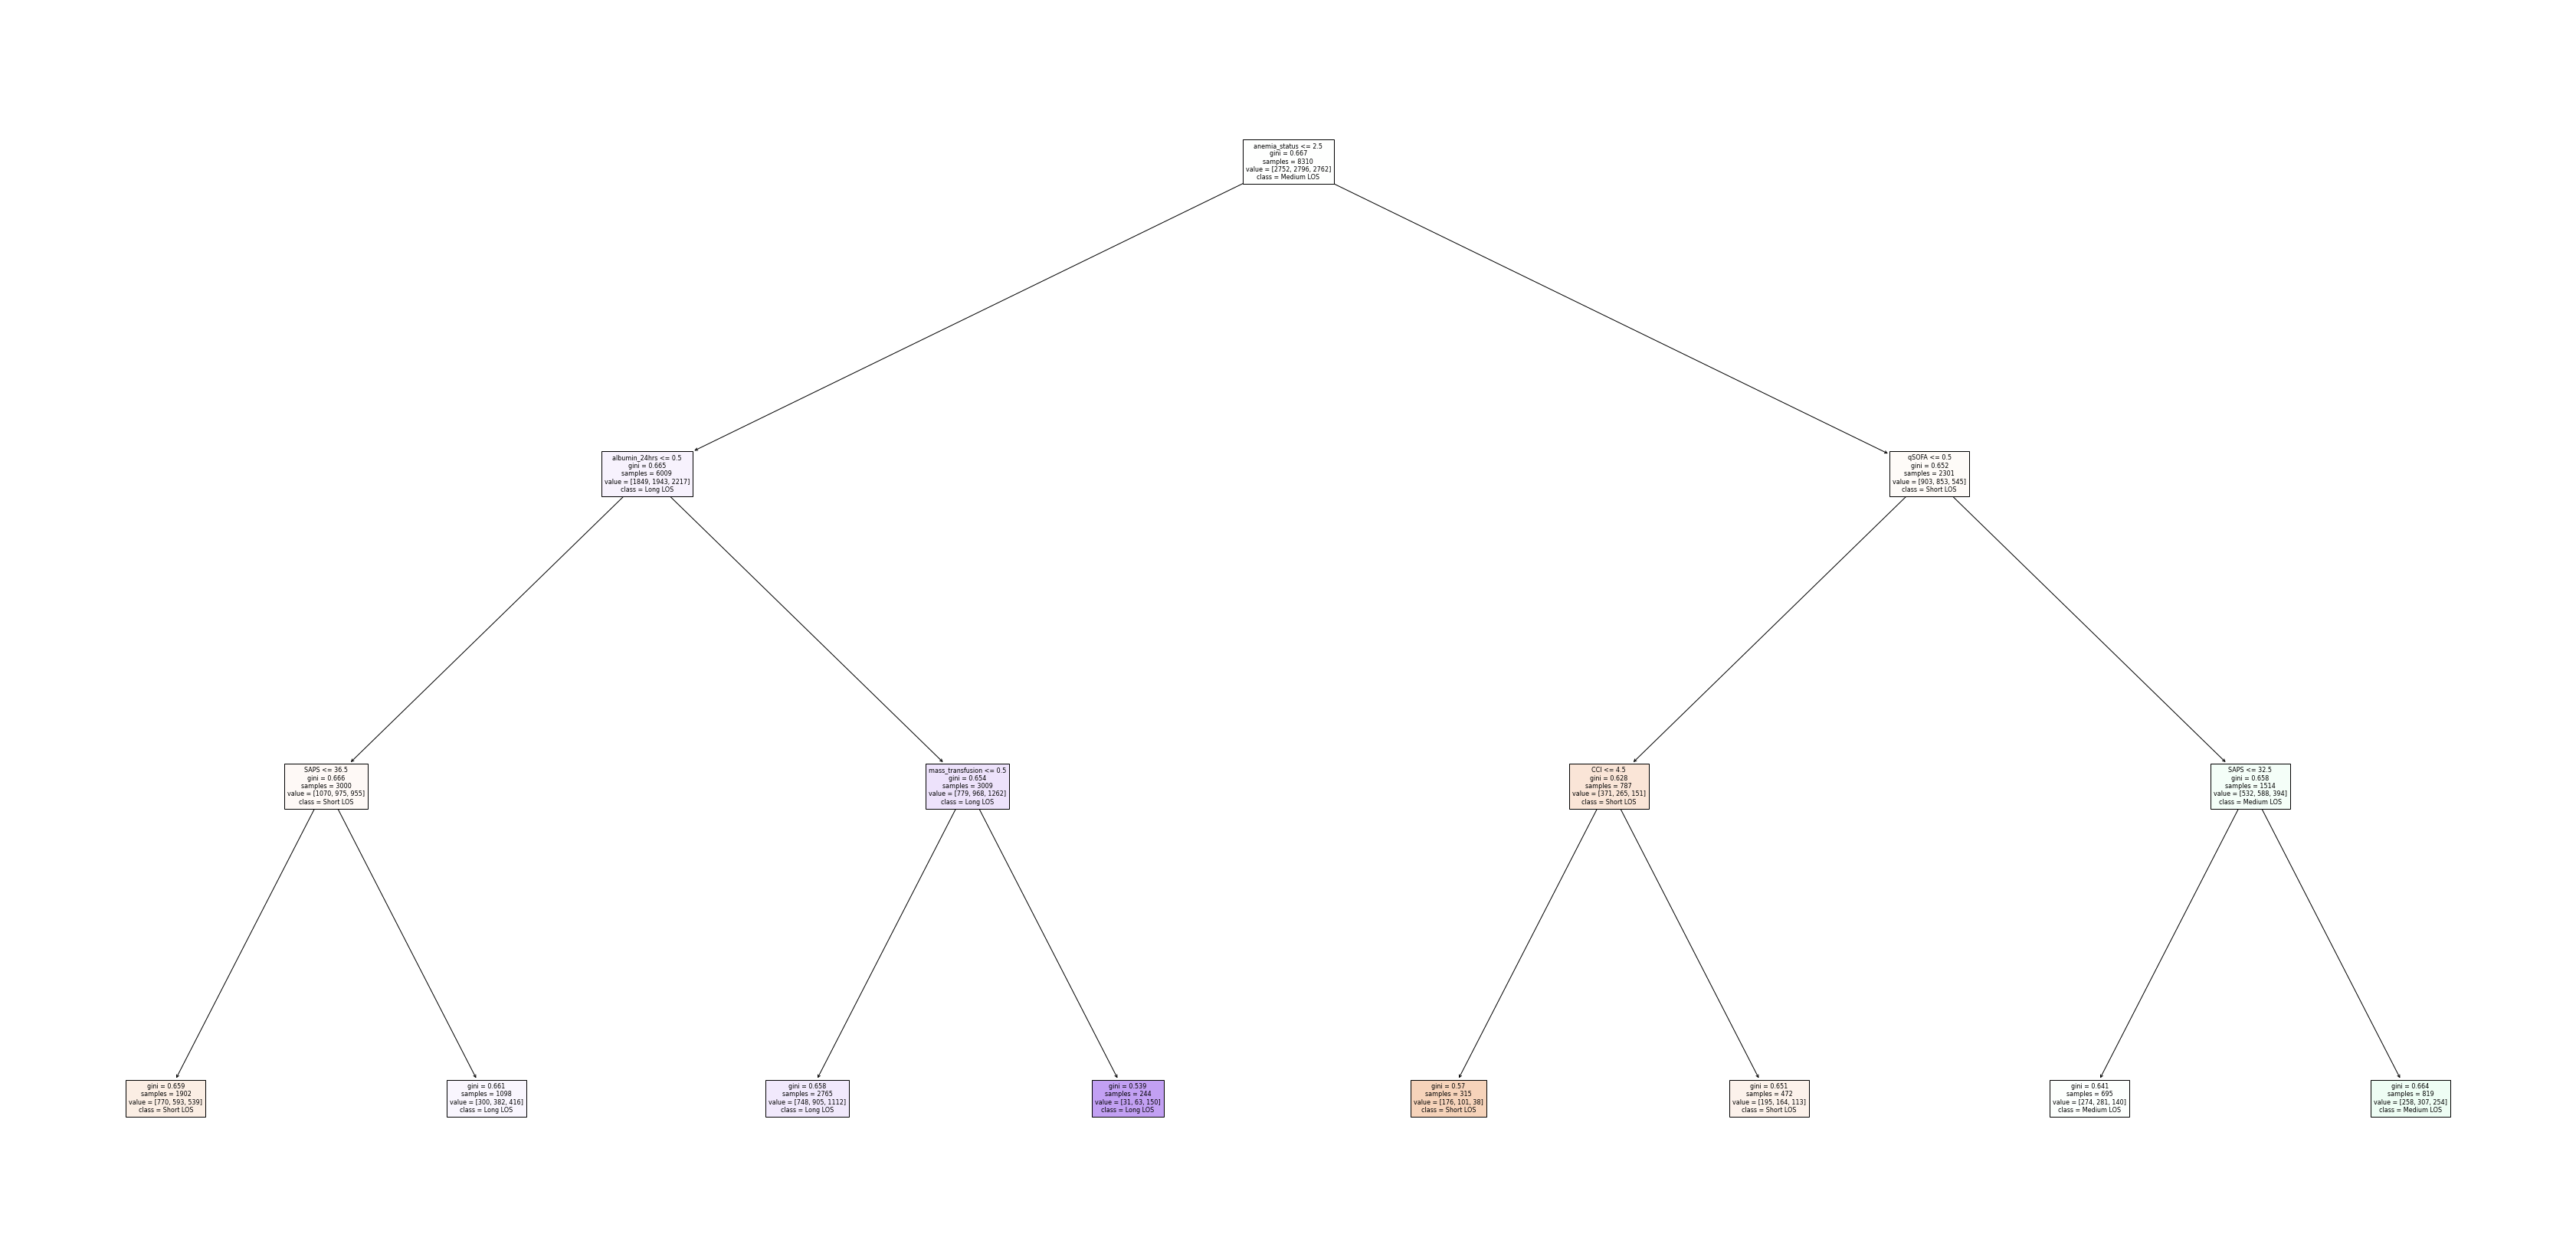

In [83]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [30]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('LOS_DT_D3_NCBL.png')

True

## 2: Decision Tree (Max Depth=4)

In [84]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.10922
Feature: total_transfusions Score: 0.03365
Feature: anemia_status Score: 0.23599
Feature: CCI Score: 0.16011
Feature: bl_albumin_value Score: 0.00000
Feature: qSOFA Score: 0.05944
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.02577
Feature: hemorrhagic Score: 0.04363
Feature: SAPS Score: 0.17529
Feature: albumin_24hrs Score: 0.15690


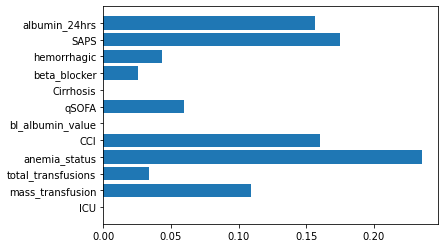

In [85]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [86]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [87]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1273  464 1015]
 [ 965  579 1252]
 [ 640  464 1658]]


In [88]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45      2752
           1       0.38      0.21      0.27      2796
           2       0.42      0.60      0.50      2762

    accuracy                           0.42      8310
   macro avg       0.42      0.42      0.41      8310
weighted avg       0.42      0.42      0.41      8310



In [89]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[310 129 263]
 [246 119 322]
 [184 110 395]]


In [90]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43       702
           1       0.33      0.17      0.23       687
           2       0.40      0.57      0.47       689

    accuracy                           0.40      2078
   macro avg       0.38      0.40      0.38      2078
weighted avg       0.39      0.40      0.38      2078



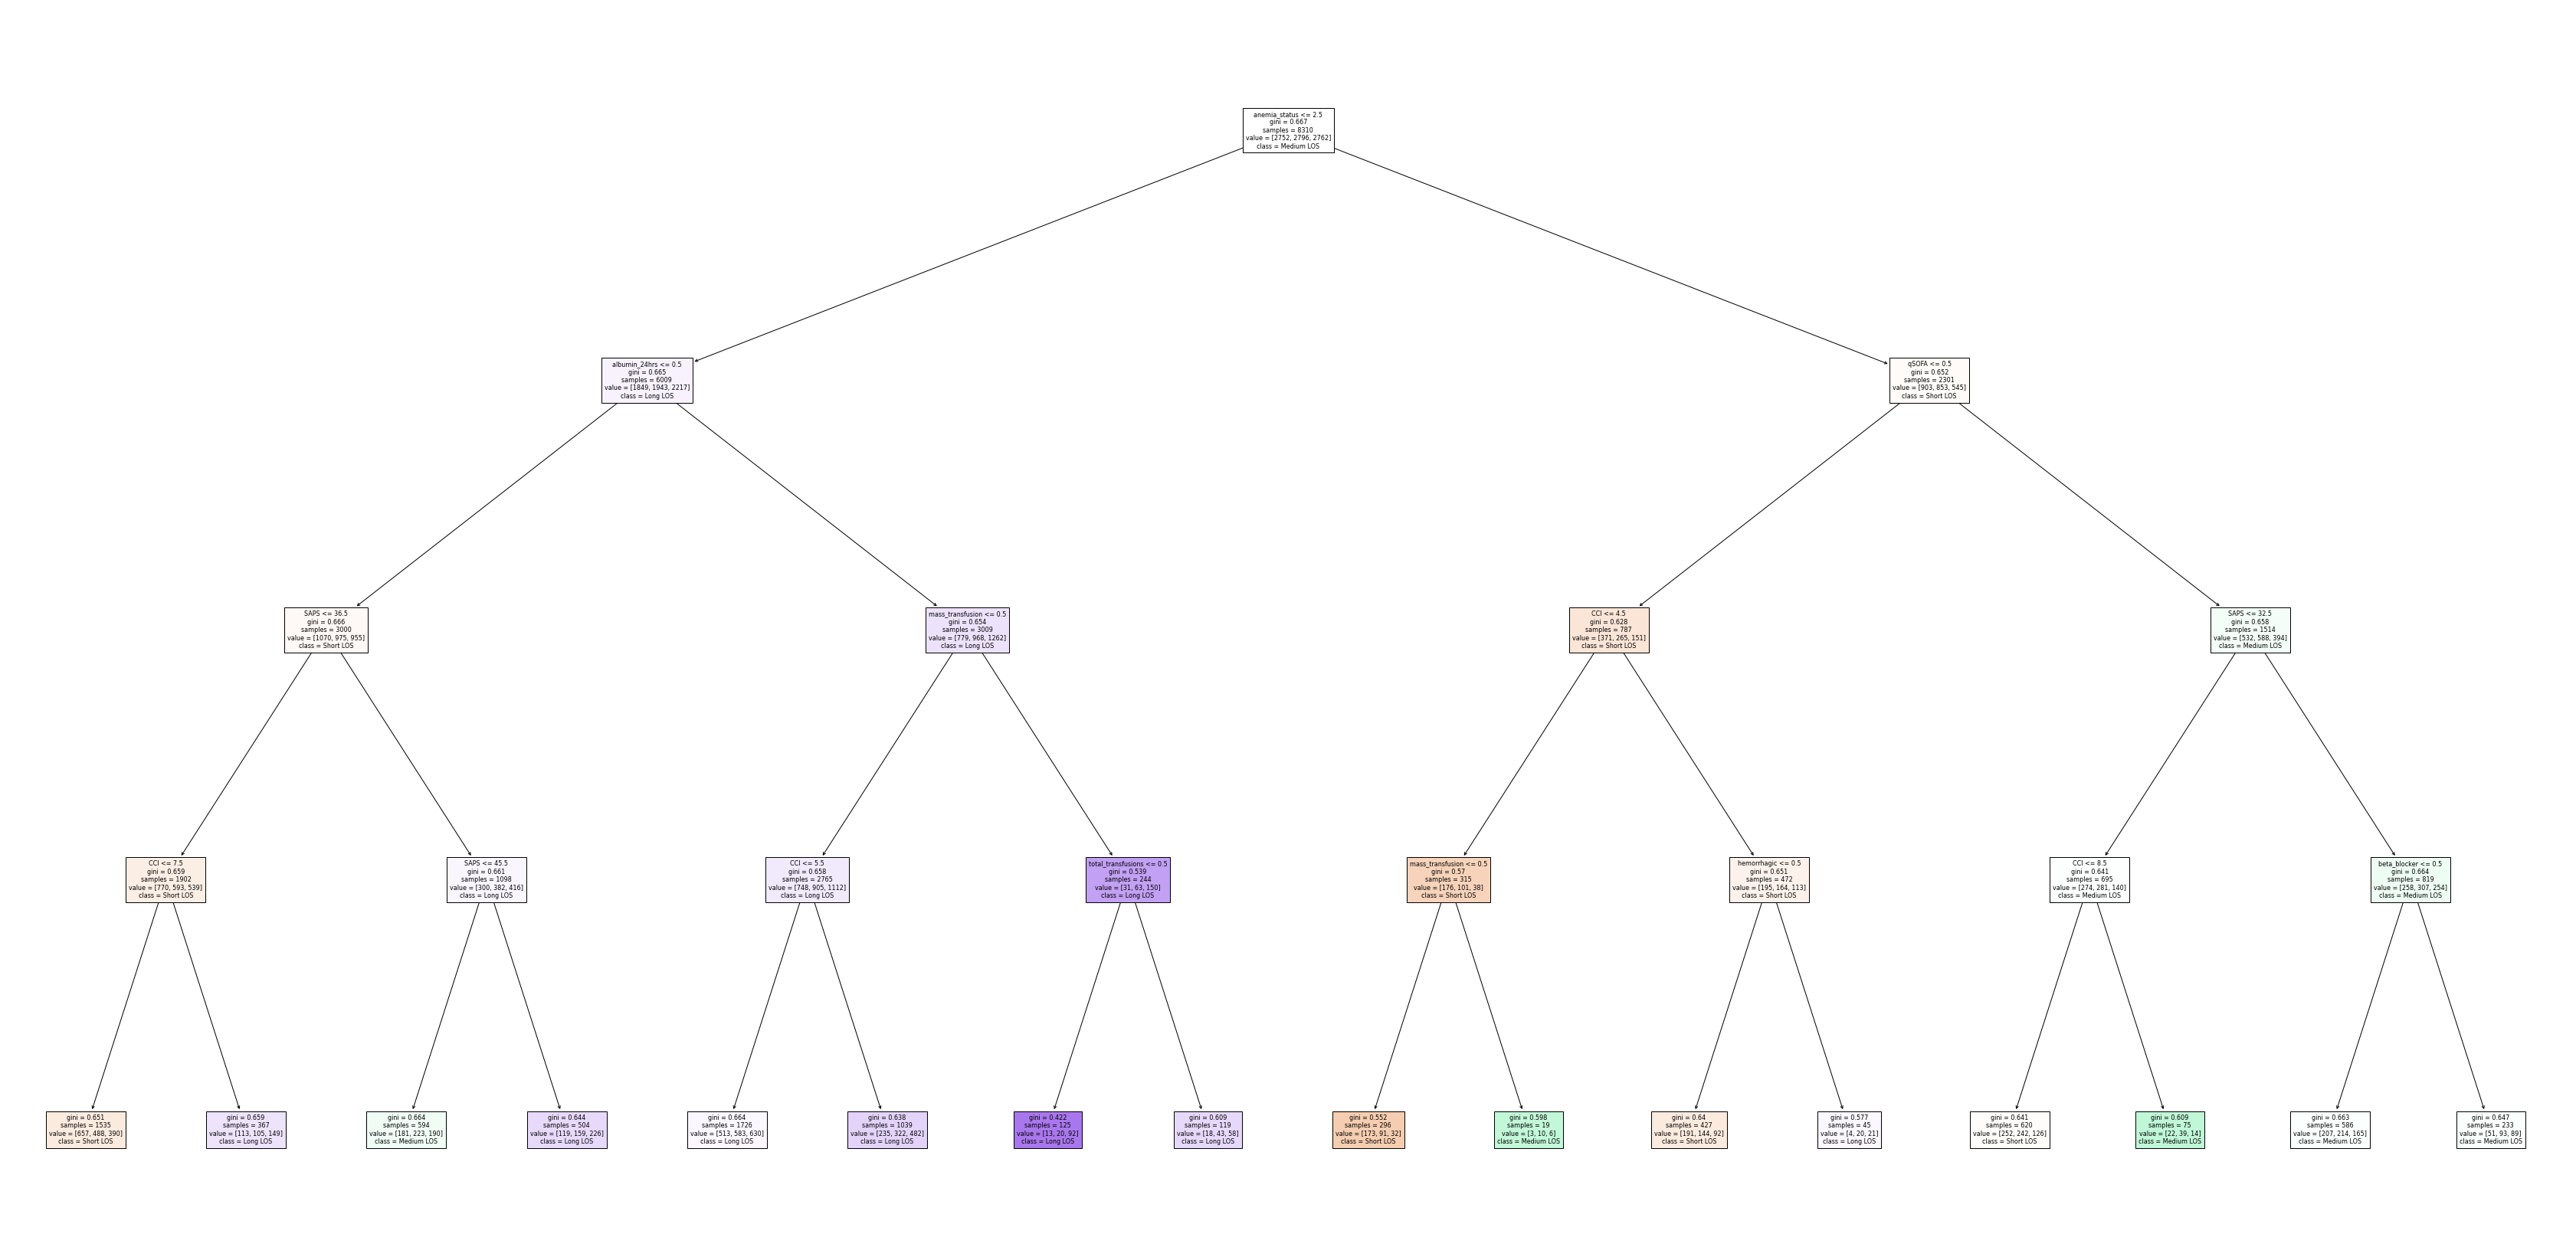

In [91]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [39]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D4_NCBL.png')

True

## 3: Decision Tree 

In [92]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

Feature: ICU Score: 0.00983
Feature: mass_transfusion Score: 0.07804
Feature: total_transfusions Score: 0.03222
Feature: anemia_status Score: 0.21621
Feature: CCI Score: 0.13547
Feature: bl_albumin_value Score: 0.08064
Feature: qSOFA Score: 0.05679
Feature: Cirrhosis Score: 0.01705
Feature: beta_blocker Score: 0.04333
Feature: hemorrhagic Score: 0.04623
Feature: SAPS Score: 0.17210
Feature: albumin_24hrs Score: 0.11210


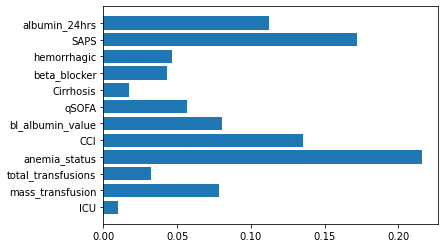

In [93]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [94]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [95]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1325  792  635]
 [ 998  959  839]
 [ 668  774 1320]]


In [96]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.44      0.48      0.46      2752
           1       0.38      0.34      0.36      2796
           2       0.47      0.48      0.48      2762

    accuracy                           0.43      8310
   macro avg       0.43      0.43      0.43      8310
weighted avg       0.43      0.43      0.43      8310



In [97]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[317 220 165]
 [241 217 229]
 [192 183 314]]


In [98]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.42      0.45      0.44       702
           1       0.35      0.32      0.33       687
           2       0.44      0.46      0.45       689

    accuracy                           0.41      2078
   macro avg       0.41      0.41      0.41      2078
weighted avg       0.41      0.41      0.41      2078



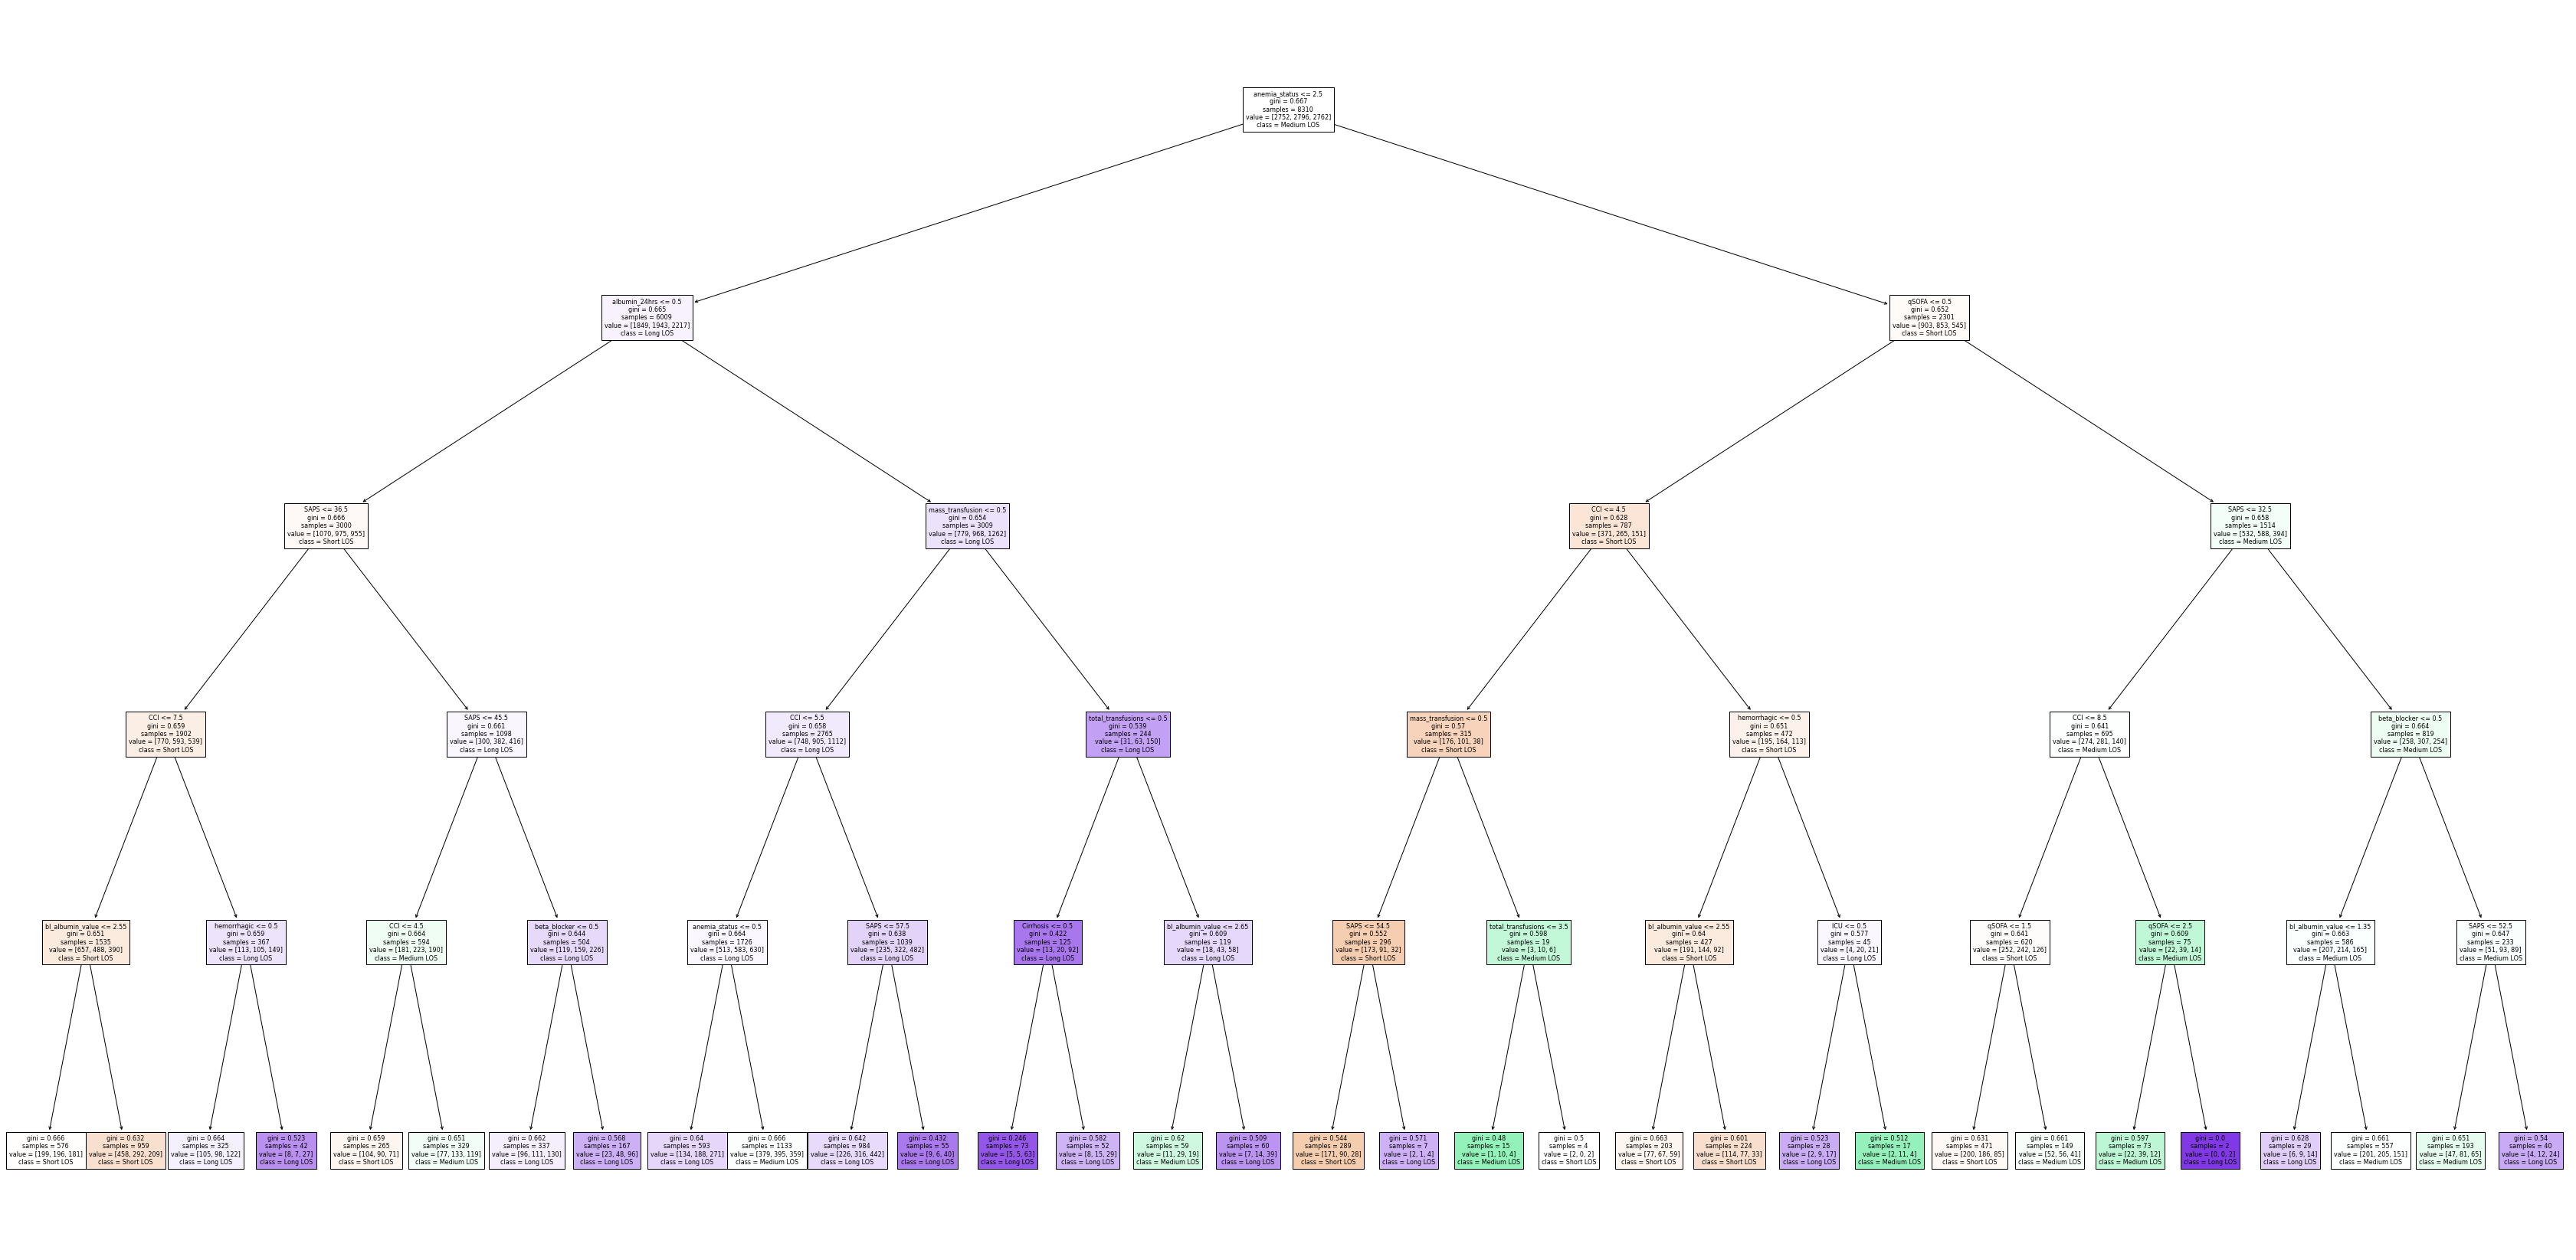

In [99]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [48]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D5_NCBL.png')

True

## 4: Decision Tree 

In [100]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Feature: ICU Score: 0.01025
Feature: mass_transfusion Score: 0.05803
Feature: total_transfusions Score: 0.02339
Feature: anemia_status Score: 0.21438
Feature: CCI Score: 0.13059
Feature: bl_albumin_value Score: 0.07302
Feature: qSOFA Score: 0.09098
Feature: Cirrhosis Score: 0.02269
Feature: beta_blocker Score: 0.04968
Feature: hemorrhagic Score: 0.00718
Feature: SAPS Score: 0.20860
Feature: albumin_24hrs Score: 0.11121


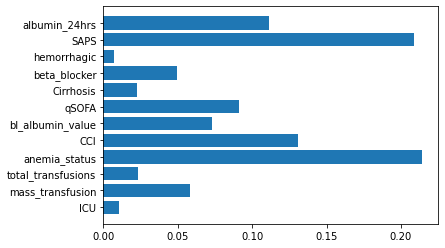

In [101]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [102]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [103]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1411  620  721]
 [1021  794  981]
 [ 704  578 1480]]


In [104]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.45      0.51      0.48      2752
           1       0.40      0.28      0.33      2796
           2       0.47      0.54      0.50      2762

    accuracy                           0.44      8310
   macro avg       0.44      0.44      0.44      8310
weighted avg       0.44      0.44      0.44      8310



In [105]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[363 166 173]
 [256 167 264]
 [194 140 355]]


In [106]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.45      0.52      0.48       702
           1       0.35      0.24      0.29       687
           2       0.45      0.52      0.48       689

    accuracy                           0.43      2078
   macro avg       0.42      0.43      0.42      2078
weighted avg       0.42      0.43      0.42      2078



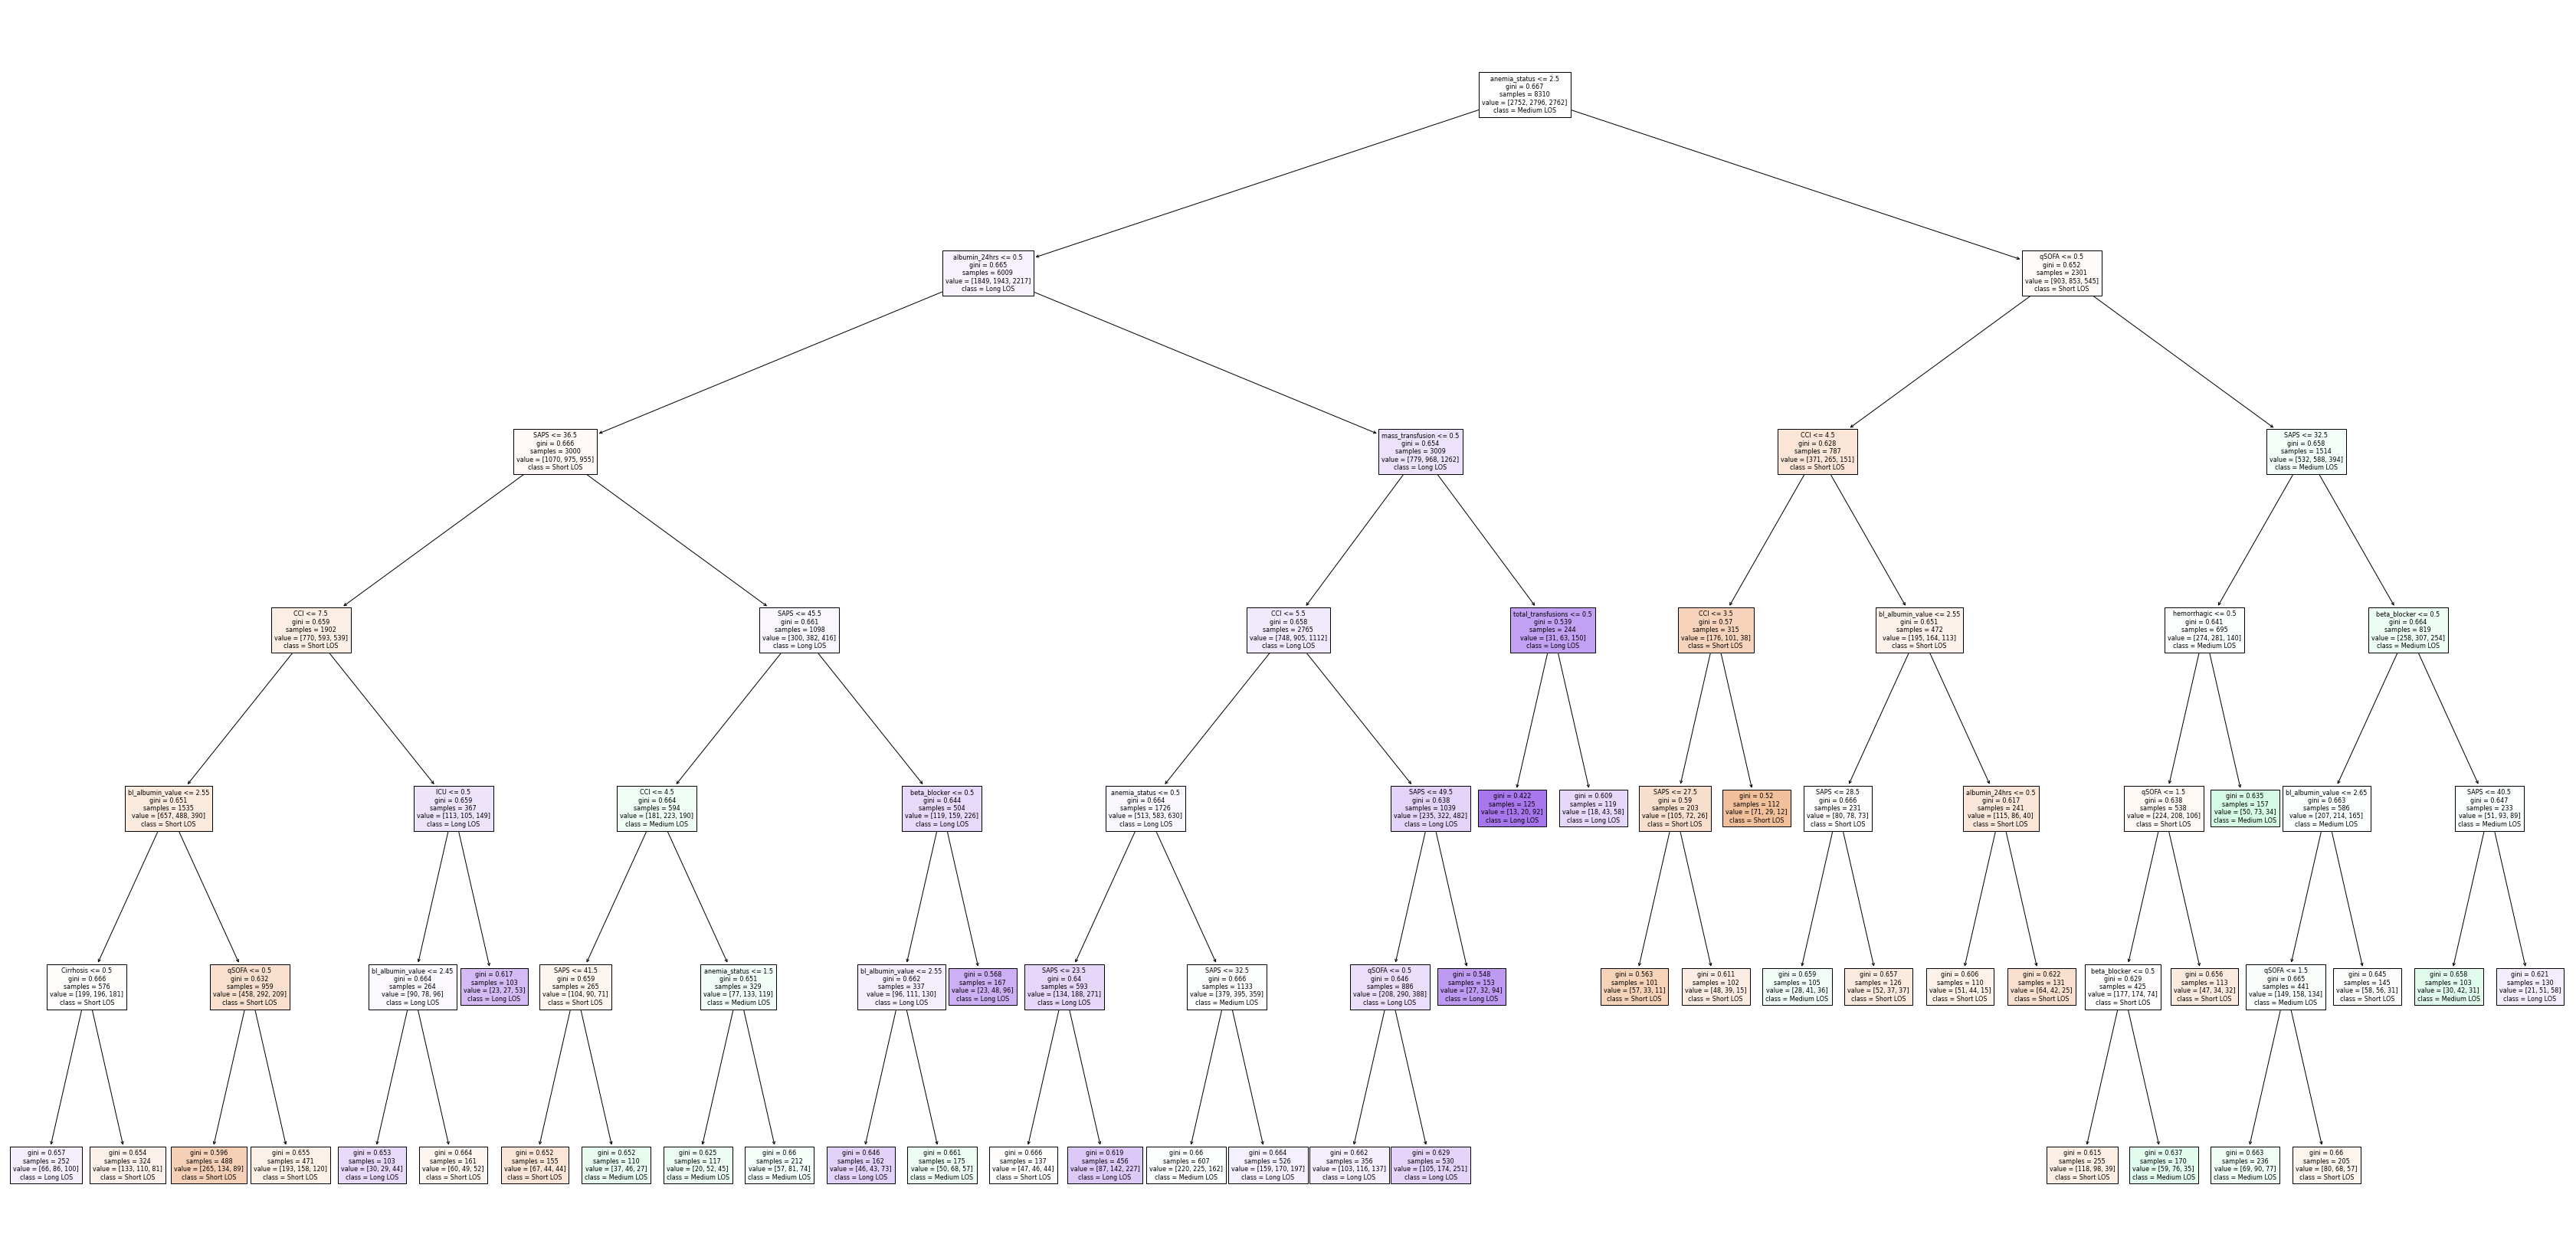

In [107]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [57]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D6_NCBL.png')

True

## 5: Decision Tree 

In [32]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.17139
Feature: Cirrhosis Score: 0.00000
Feature: CCI Score: 0.29509
Feature: qSOFA Score: 0.08422
Feature: MELD Score: 0.22749
Feature: SEWS Score: 0.10859
Feature: albumin_24hrs Score: 0.11322


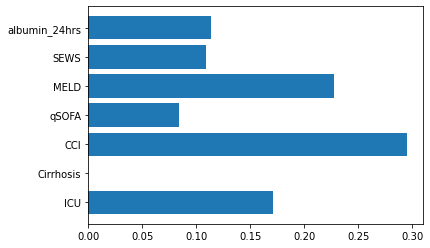

In [33]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [34]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [35]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1749  818  971]
 [ 979 1220 1373]
 [ 646  809 2065]]


In [36]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.52      0.49      0.51      3538
           1       0.43      0.34      0.38      3572
           2       0.47      0.59      0.52      3520

    accuracy                           0.47     10630
   macro avg       0.47      0.47      0.47     10630
weighted avg       0.47      0.47      0.47     10630



In [37]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[387 251 253]
 [234 238 390]
 [159 212 534]]


In [38]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       891
           1       0.34      0.28      0.30       862
           2       0.45      0.59      0.51       905

    accuracy                           0.44      2658
   macro avg       0.43      0.43      0.43      2658
weighted avg       0.43      0.44      0.43      2658



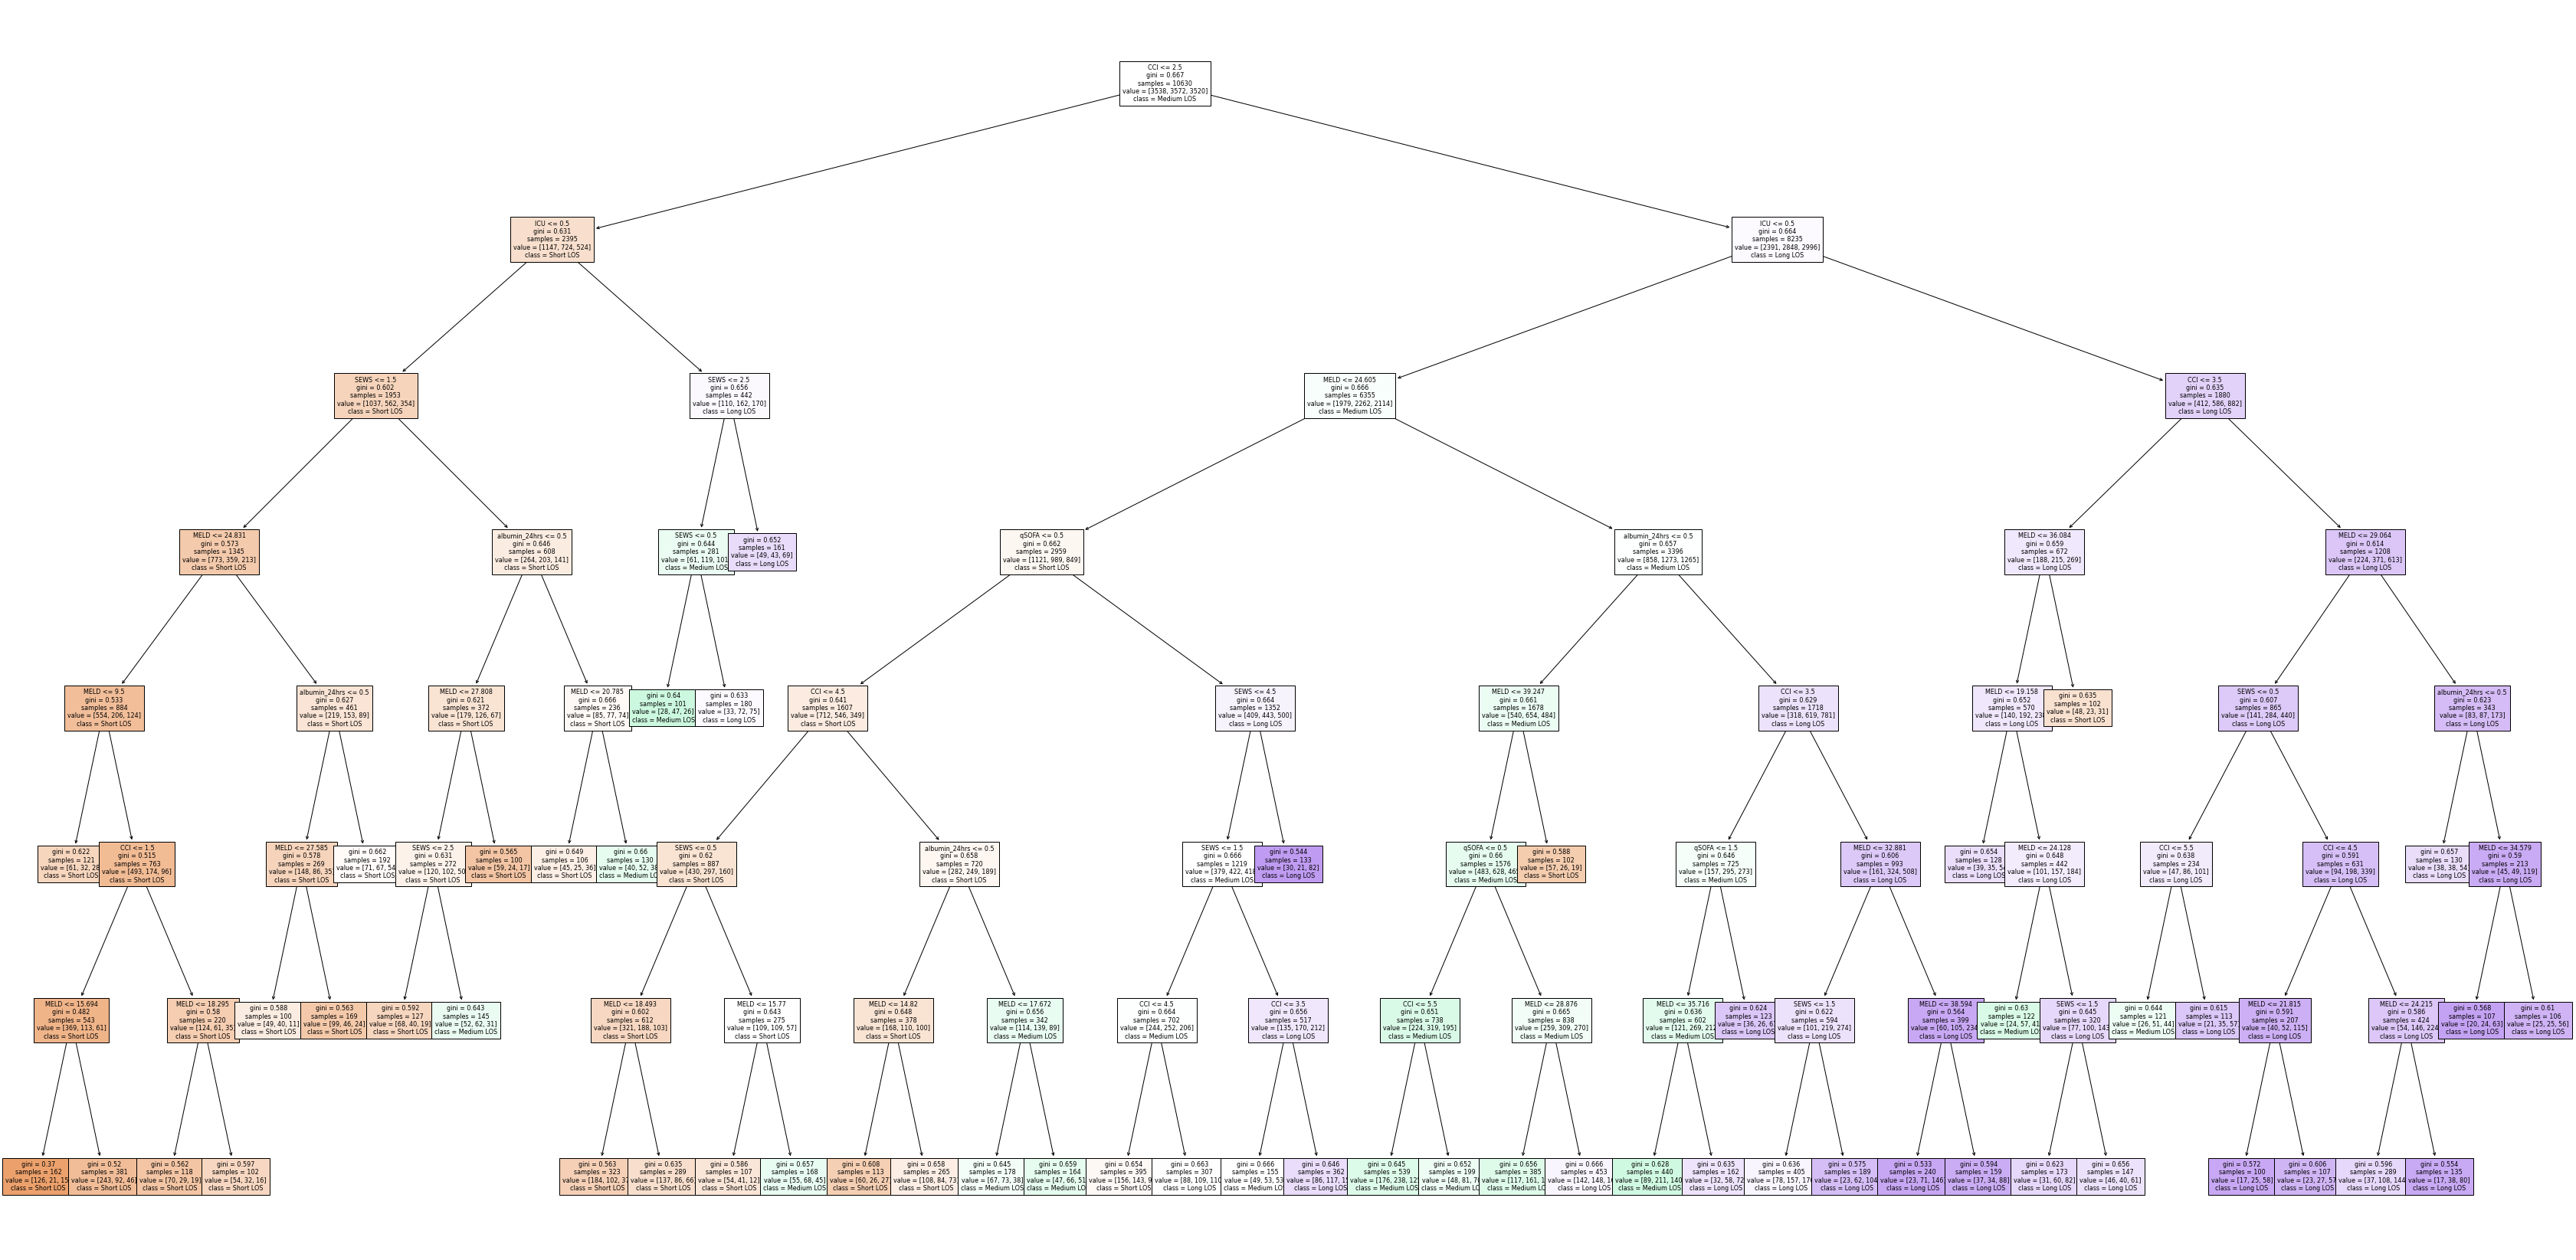

In [39]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [40]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D7_PSM_MATCHED.png')

True

## Random Forest

In [67]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [68]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [69]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[18672   637  2957]
 [ 9614   836  3514]
 [ 6440   612  5605]]


In [70]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.54      0.84      0.66     22266
           1       0.40      0.06      0.10     13964
           2       0.46      0.44      0.45     12657

    accuracy                           0.51     48887
   macro avg       0.47      0.45      0.40     48887
weighted avg       0.48      0.51      0.45     48887



In [71]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4688  168  776]
 [2396  191  886]
 [1603  152 1362]]


In [72]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.54      0.83      0.65      5632
           1       0.37      0.05      0.10      3473
           2       0.45      0.44      0.44      3117

    accuracy                           0.51     12222
   macro avg       0.45      0.44      0.40     12222
weighted avg       0.47      0.51      0.44     12222



Feature: anemia_status Score: 0.16072
Feature: CCI Score: 0.41386
Feature: albumin_24hrs Score: 0.03637
Feature: qSOFA Score: 0.17950
Feature: SAPS Score: 0.20956


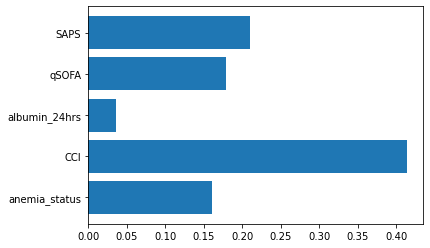

In [73]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()